$$
\begin{align}
    p(\xi) &= \mathcal{U}(-5, 5) \\
    p_\epsilon(y^*\mid y) &= \mathbb{I}[\|y - y^*\| \leq \epsilon]
\end{align}
$$

# Experiment 13 - Uniform kernel, Uniform prior

In [70]:
import numpy as np
from numpy import zeros, diag, eye, log, pi, sqrt, vstack, exp, mean, load
from numpy.linalg import solve
from scipy.stats import multivariate_normal as MVN
from tangential_hug_functions import Hug, HugTangential, Hop, run_hug_hop, run_thug_hop, HugStepEJSD, HugTangentialStepEJSD
from utils import ESS, quick_MVN_scatter, prep_contour, quick_MVN_marginals, MVN_scatters
import matplotlib.pyplot as plt
from scipy.stats import norm as ndist
from numpy.random import uniform, normal
from scipy.special import gammaincc
from scipy.special import gamma, erf
import tensorflow_probability as tfp
from scipy.optimize import root
from utils import ESS_univariate, box_plot
from IPython.display import display, Latex
from utils import ESS_univariate, ESS

In [29]:
# HUG
THETA_ESS_HUG = load("experiment13/THETA_ESS_HUG.npy")
U_ESS_HUG     = load("experiment13/U_ESS_HUG.npy")
ESS_JOINT_HUG = load("experiment13/ESS_JOINT_HUG.npy")
ESS_LOGPI_HUG = load("experiment13/ESS_LOGPI_HUG.npy")
A_HUG         = load("experiment13/A_HUG.npy")
RMSE_HUG      = load("experiment13/RMSE_HUG.npy")
EJSD_HUG      = load("experiment13/EJSD_HUG.npy")
G_EJSD_HUG    = load("experiment13/G_EJSD_HUG.npy")
T_EJSD_HUG    = load("experiment13/T_EJSD_HUG.npy")
A_HOP_HUG     = load("experiment13/A_HOP_HUG.npy")

# THUG
THETA_ESS_THUG = load("experiment13/THETA_ESS_THUG.npy")
U_ESS_THUG     = load("experiment13/U_ESS_THUG.npy")
ESS_JOINT_THUG = load("experiment13/ESS_JOINT_THUG.npy")
ESS_LOGPI_THUG = load("experiment13/ESS_LOGPI_THUG.npy")
A_THUG         = load("experiment13/A_THUG.npy")
RMSE_THUG      = load("experiment13/RMSE_THUG.npy")
EJSD_THUG      = load("experiment13/EJSD_THUG.npy")
G_EJSD_THUG    = load("experiment13/G_EJSD_THUG.npy")
T_EJSD_THUG    = load("experiment13/T_EJSD_THUG.npy")
A_HOP_THUG     = load("experiment13/A_HOP_THUG.npy")

# COMMON
EPSILONS       = load("experiment13/EPSILONS.npy")
ALPHAS         = load("experiment13/ALPHAS.npy")

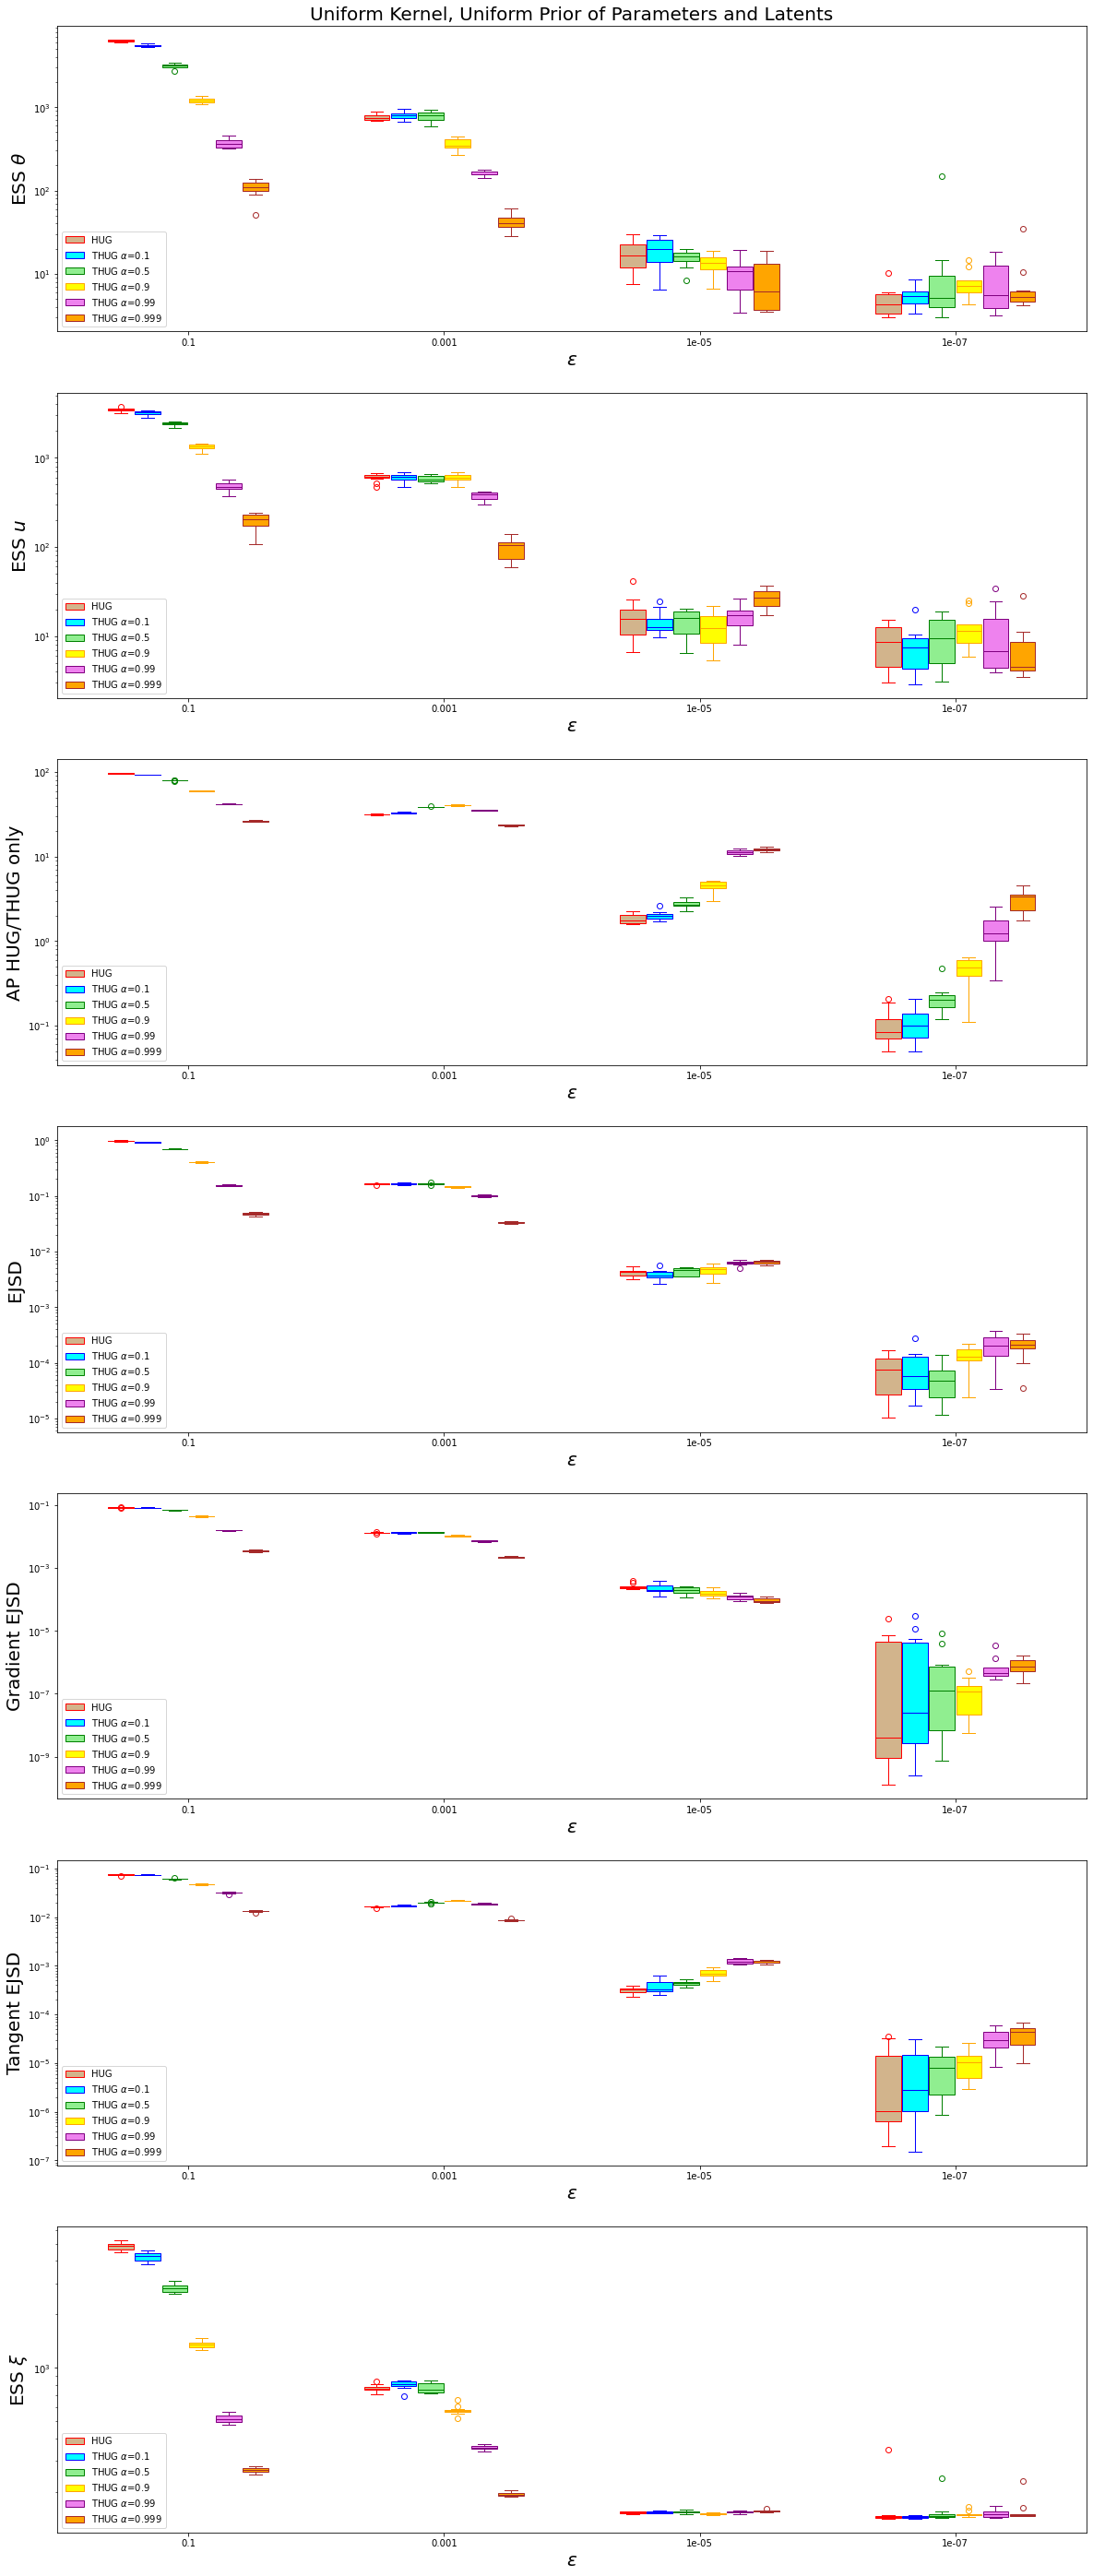

In [30]:
columns = EPSILONS
width = 0.21
n_alphas = len(ALPHAS)
ticks = np.arange(start=1, stop=len(EPSILONS)*2, step=2)
n_boxes = n_alphas + 1
disp = np.linspace(-width * (n_boxes-1) / 2, width * (n_boxes-1) / 2, n_boxes, endpoint=True)
positions = disp.reshape(-1, 1) + ticks
colors1 = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'black']
colors2 = ['tan', 'cyan', 'lightgreen', 'yellow', 'violet', 'orange', 'lightgray']

fig, ax = plt.subplots(nrows=7, figsize=(20, 50))
# Univariate ESS for \theta chain
bp1 = box_plot(ax[0], THETA_ESS_HUG.T.tolist(), 'red', 'tan', positions[0])
bps = []
for i in range(len(ALPHAS)):
    bps.append(box_plot(ax[0], THETA_ESS_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1["boxes"][0]] + [bp["boxes"][0] for bp in bps]
labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
ax[0].legend(
    handles, 
    labels, 
    loc='lower left')
ax[0].set_xticks(ticks)
ax[0].set_xticklabels(columns)
ax[0].set_xlabel("$\\epsilon$", fontsize=20)
ax[0].set_ylabel("ESS $\\theta$", fontsize=20)
ax[0].semilogy()

# Univariate ESS for u chain
bp1 = box_plot(ax[1], U_ESS_HUG.T.tolist(), 'red', 'tan', positions[0])
bps = []
for i in range(len(ALPHAS)):
    bps.append(box_plot(ax[1], U_ESS_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1["boxes"][0]] + [bp["boxes"][0] for bp in bps]
labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
ax[1].legend(
    handles, 
    labels, 
    loc='lower left')
ax[1].set_xticks(ticks)
ax[1].set_xticklabels(columns)
ax[1].set_xlabel("$\\epsilon$", fontsize=20)
ax[1].set_ylabel("ESS $u$", fontsize=20)
ax[1].semilogy()

# ACCEPTANCE PROBABILITY 
bp1_a = box_plot(ax[2], A_HUG.T.tolist(), 'red', 'tan', positions[0])
bps_a = []
for i in range(len(ALPHAS)):
    bps_a.append(box_plot(ax[2], A_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1_a["boxes"][0]] + [bp["boxes"][0] for bp in bps_a]
labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
ax[2].legend(
    handles, 
    labels, 
    loc='lower left')
ax[2].set_xticks(ticks)
ax[2].set_xticklabels(columns)
ax[2].set_xlabel("$\\epsilon$", fontsize=20)
ax[2].set_ylabel("AP HUG/THUG only", fontsize=20)
ax[2].semilogy()

#EJSD
bp1_e = box_plot(ax[3], EJSD_HUG.T.tolist(), 'red', 'tan', positions[0])
bps_e = []
for i in range(len(ALPHAS)):
    bps_e.append(box_plot(ax[3], EJSD_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1_e["boxes"][0]] + [bp["boxes"][0] for bp in bps_e]
labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
ax[3].legend(
    handles, 
    labels, 
    loc='lower left')
ax[3].set_xticks(ticks)
ax[3].set_xticklabels(columns)
ax[3].set_xlabel("$\\epsilon$", fontsize=20)
ax[3].set_ylabel("EJSD", fontsize=20)
ax[3].semilogy()

# EJSD on Gradient Direction
bp1_eg = box_plot(ax[4], G_EJSD_HUG.T.tolist(), 'red', 'tan', positions[0])
bps_eg = []
for i in range(len(ALPHAS)):
    bps_eg.append(box_plot(ax[4], G_EJSD_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1_eg["boxes"][0]] + [bp["boxes"][0] for bp in bps_eg]
labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
ax[4].legend(
    handles, 
    labels, 
    loc='lower left')
ax[4].set_xticks(ticks)
ax[4].set_xticklabels(columns)
ax[4].set_xlabel("$\\epsilon$", fontsize=20)
ax[4].set_ylabel("Gradient EJSD", fontsize=20)
ax[4].semilogy()


# EJSD on Tangent Direction
bp1_et = box_plot(ax[5], T_EJSD_HUG.T.tolist(), 'red', 'tan', positions[0])
bps_et = []
for i in range(len(ALPHAS)):
    bps_et.append(box_plot(ax[5], T_EJSD_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1_et["boxes"][0]] + [bp["boxes"][0] for bp in bps_et]
labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
ax[5].legend(
    handles, 
    labels, 
    loc='lower left')
ax[5].set_xticks(ticks)
ax[5].set_xticklabels(columns)
ax[5].set_xlabel("$\\epsilon$", fontsize=20)
ax[5].set_ylabel("Tangent EJSD", fontsize=20)
ax[5].semilogy()

# Joint ESS for u chain
bp1_jess = box_plot(ax[6], ESS_JOINT_HUG.T.tolist(), 'red', 'tan', positions[0])
bps_jess = []
for i in range(len(ALPHAS)):
    bps_jess.append(box_plot(ax[6], ESS_JOINT_THUG[:,:,i].T.tolist(), colors1[i+1], colors2[i+1], positions[i+1]))
handles = [bp1_jess["boxes"][0]] + [bp["boxes"][0] for bp in bps_jess]
labels = ['HUG'] + ['THUG $\\alpha$={}'.format(alpha) for alpha in ALPHAS]
ax[6].legend(
    handles, 
    labels, 
    loc='lower left')
ax[6].set_xticks(ticks)
ax[6].set_xticklabels(columns)
ax[6].set_xlabel("$\\epsilon$", fontsize=20)
ax[6].set_ylabel("ESS $\\xi$", fontsize=20)
ax[6].semilogy()


ax[0].set_title("Uniform Kernel, Uniform Prior of Parameters and Latents", fontsize=20)
plt.show()

# Exploring ESS

In [68]:
def log_uniform_kernel(xi, epsilon):
    """Log density of uniform kernel. """
    with np.errstate(divide='ignore'):
        return log((abs(target.logpdf(xi) - z0) <= epsilon).astype('float64'))
    
def logprior_uniform(xi):
    """Log density for uniform prior p(xi) of parameters and latents U([-5,5]x[-5,5])."""
    with np.errstate(divide='ignore'):
        return log((abs(xi) <= 5.0).all().astype('float64'))

def logprior_uniform_all(xi):
    """Log density for uniform prior p(xi) of parameters and latents U([-5,5]x[-5,5])."""
    with np.errstate(divide='ignore'):
        return log((abs(xi) <= 5.0).all(axis=1).astype('float64'))
    
def log_abc_posterior(xi):
    """Log density of ABC posterior. Product of (param-latent) prior and uniform kernel."""
    return logprior_uniform(xi) + log_uniform_kernel(xi, epsilon)

def log_abc_posterior_all(xi):
    """Log density of ABC posterior. Product of (param-latent) prior and uniform kernel."""
    return logprior_uniform_all(xi) + log_uniform_kernel(xi, epsilon)
    
def grad_log_simulator(xi):
    """Gradient of log simulator N(mu, Sigma)."""
    return - solve(Sigma, xi)


def runHH(x0, lam, N):
    """Runs HUG and HOP."""
    samples = x = x0
    accept1 = zeros(N)
    accept2 = zeros(N)
    esjd = 0.0
    esjd_grad = 0.0
    esjd_tan = 0.0
    for _ in range(N):
        y, a1, e, eg, et = HugStepEJSD(x, T, B, q, log_abc_posterior, grad_log_simulator)
        x, a2 = Hop(y, lam, kappa, log_abc_posterior, grad_log_simulator)
        samples = vstack((samples, y, x))
        accept1[_], accept2[_] = a1, a2
        esjd += e / N
        esjd_grad += eg / N 
        esjd_tan += et / N 
    return samples[1:], mean(accept1)*100, mean(accept2)*100, esjd, esjd_grad, esjd_tan


def runTH(x0, lam, N):
    """Runs THUG and HOP."""
    samples = x = x0
    accept1 = zeros(N)
    accept2 = zeros(N)
    esjd = 0.0
    esjd_grad = 0.0
    esjd_tan = 0.0
    for _ in range(N):
        y, a1, e, eg, et = HugTangentialStepEJSD(x, T, B, alpha, q, log_abc_posterior, grad_log_simulator)
        x, a2 = Hop(y, lam, kappa, log_abc_posterior, grad_log_simulator)
        samples = vstack((samples, y, x))
        accept1[_], accept2[_] = a1, a2
        esjd += e / N
        esjd_grad += eg / N 
        esjd_tan += et / N 
    return samples[1:], mean(accept1)*100, mean(accept2)*100, esjd, esjd_grad, esjd_tan


def runTHAR(x0, lam, N):
    """Runs THUG-AR and HOP"""
    samples = x = x0
    accept1 = zeros(N)
    accept2 = zeros(N)
    esjd = 0.0
    esjd_grad = 0.0
    esjd_tan = 0.0
    for _ in range(N):
        y, a1, e, eg, et = HugTangentialStepEJSD(x, T, B, alpha, q, log_abc_posterior, grad_log_simulator)
        x, a2 = Hop(y, lam, kappa, log_abc_posterior, grad_log_simulator)
        samples = vstack((samples, y, x))
        accept1[_], accept2[_] = a1, a2
        esjd += e / N
        esjd_grad += eg / N 
        esjd_tan += et / N 
    return samples[1:], mean(accept1)*100, mean(accept2)*100, esjd, esjd_grad, esjd_tan
        


In [66]:
# Target distribution is a diagonal MVN
Sigma0 = diag([1.0, 5.0])
rho = 1.0
Sigma = rho * Sigma0
target = MVN(zeros(2), Sigma)

# Initial point on z0-contour
x0 = normal(size=2)                           # Keep initial point the same
z0 = target.logpdf(x0)                        # Feed through simulator

# Proposal for velocity in HUG/THUG
q = MVN(zeros(2), eye(2))




In [165]:
# Settings
T = 1.5
B = 5
N = 10000
kappa = 0.25
n_runs = 1

epsilon = 0.1
alpha = 0.9
lam = epsilon  

for i in range(n_runs):
    # HUG
    hug, ahug, ahop, e, eg, et = runHH(x0, lam, N)
    # THUG
    thug, athug, ahop, e, eg, et = runTH(x0, lam, N)

### Overall $\theta$ ESS

In [173]:
theta_ESS_hug  = ESS_univariate(hug[:, 0])
theta_ESS_thug = ESS_univariate(thug[:, 0])
print("HUG:   {:.5}".format(theta_ESS_hug))
print("THUG:  {:.5}".format(theta_ESS_thug))
print("Percentage Decrease: {:.2%}".format((theta_ESS_hug - theta_ESS_thug)/theta_ESS_hug))

HUG:   4280.3
THUG:  1016.5
Percentage Decrease: 76.25%


### $\theta$ ESS for HUG/THUG samples only 

In [176]:
theta_ESS_hug_only  = ESS_univariate(hug[::2, 0])
theta_ESS_thug_only = ESS_univariate(thug[::2, 0])
print("HUG:  {:.5}".format(theta_ESS_hug_only))
print("THUG: {:.5}".format(theta_ESS_thug_only))
print("Percentage Decrease: {:.2%}".format((theta_ESS_hug_only-theta_ESS_thug_only)/theta_ESS_hug_only))

HUG:  4254.9
THUG: 1015.7
Percentage Decrease: 76.13%


### $\theta$ ESS for HOP samples only

In [177]:
theta_ESS_hop_hug  = ESS_univariate(hug[1::2, 0])
theta_ESS_hop_thug = ESS_univariate(thug[1::2, 0])
print("HUG:  {:.5}".format(theta_ESS_hop_hug))
print("THUG: {:.5}".format(theta_ESS_hop_thug))
print("Percentage Decrease: {:.2%}".format((theta_ESS_hop_hug-theta_ESS_hop_thug)/theta_ESS_hop_hug))

HUG:  4273.6
THUG: 1015.4
Percentage Decrease: 76.24%


### Unique Samples

In [202]:
n_unique_hh = np.unique(hug, axis=0).shape[0]
n_unique_hug = np.unique(hug[::2], axis=0).shape[0]
n_unique_hop_hug = np.unique(hug[1::2], axis=0).shape[0]

n_unique_th = np.unique(thug, axis=0).shape[0]
n_unique_thug = np.unique(thug[::2], axis=0).shape[0]
n_unique_hop_thug = np.unique(thug[1::2], axis=0).shape[0]

print("HUG & HOP:  {}".format(n_unique_hh))
print("THUG & HOP: {}".format(n_unique_th))
print("Percentage Decrease: {:.2%}".format((n_unique_hh-n_unique_th)/n_unique_hh))
print("-"*25)
print("HUG only:  {}".format(n_unique_hug))
print("THUG only: {}".format(n_unique_thug))
print("Percentage Decrease: {:.2%}".format((n_unique_hug-n_unique_thug)/n_unique_hug))
print("-"*25)
print("Hop (HUG) only:  {}".format(n_unique_hop_hug))
print("Hop (THUG) only: {}".format(n_unique_hop_thug))
print("Percentage Decrease: {:.2%}".format((n_unique_hop_hug-n_unique_hop_thug)/n_unique_hop_hug))
print("-"*25)
print("They don't sum up cause a lot of repeated samples happen when switching between Hug/Thug and Hop.")

HUG & HOP:  16934
THUG & HOP: 13949
Percentage Decrease: 17.63%
-------------------------
HUG only:  9852
THUG only: 9137
Percentage Decrease: 7.26%
-------------------------
Hop (HUG) only:  9852
Hop (THUG) only: 9133
Percentage Decrease: 7.30%
-------------------------
They don't sum up cause a lot of repeated samples happen when switching between Hug/Thug and Hop.


### Rejections and Acceptance Probability

In [209]:
# I need to build a function that computes all these things.
def rejections(x):
    """Takes a (n, 2) set of samples and returns varios stuff."""
    n = len(x)
    previous = x[0]    # First sample is a hug/thug sample
    hug_rejections = 0
    hop_rejections = 0
    for i in range(1, n):
        if np.array_equal(previous, x[i]):  # Then there has been a rejection
            if i % 2 == 1:
                hop_rejections += 1
            else:
                hug_rejections += 1
        previous = x[i]
    return hug_rejections, hop_rejections

In [236]:
ahug, athug, (N - rejections(hug)[0]) / N, (N - rejections(thug)[0]) / N

(96.85000000000001, 68.95, 0.9685, 0.6895)

Perhaps I could start recording WHY it fails. 
- Does it fail because it is outside the epsilon region?
- Does THUG fail because it stepped too far and the change in kinetic energy is too large?
- Does THUG fail because it the change in potential energy is too large?
Difficult to discern whether it's due to $\Delta k$ or $\Delta \ell$. 

### Visual Inspection

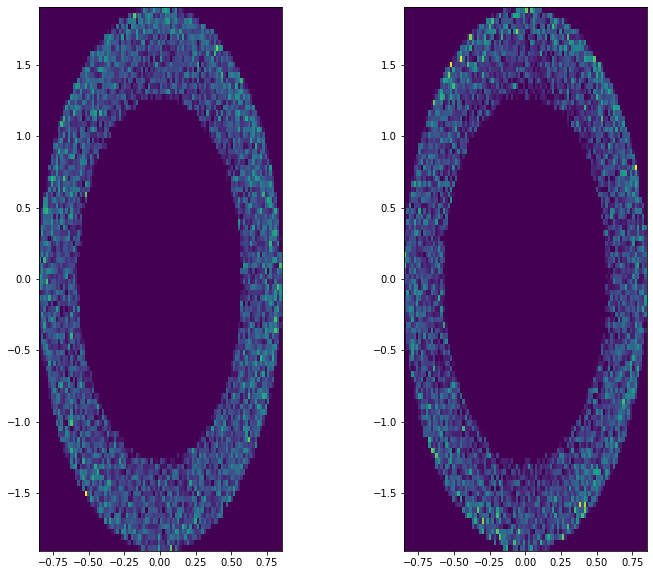

In [234]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 10))
_ = ax[0].hist2d(*hug.T, bins=100)
ax[0].set_aspect("equal")
_ = ax[1].hist2d(*thug.T, bins=100)
ax[1].set_aspect("equal")